In [1]:
matplotlib inline

In [2]:
from iuvs import meta

/Users/klay6683/miniconda3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from pathlib import Path
# root = Path('/home/klay6683/to_keep')
root = Path('/Users/klay6683/data/iuvs')
# df = pd.read_hdf('/home/klay6683/to_keep/l1a_dark_scan.h5', 'df')
df = pd.read_hdf(str(root / 'l1a_dark_scan.h5'), 'df')

## using previously defined clean up function

In [4]:
df = meta.clean_up_dark_scan(df)

#### creating little checking function:

In [5]:
def check_values(col):
    return df[col.upper()].value_counts(dropna=False)

## filter further down
remove cruise and transition and only consider 3 int_times for now

In [6]:
df = df[df.COLLECTION_ID!='cruise']

df = df[df.COLLECTION_ID!='transition']

df = df[df.INT_TIME.isin([14400, 4200, 1400])]

In [13]:
df.BINNING_SET = df.BINNING_SET.astype('category')

## load HK data

In [7]:
from iuvs import hk

hkdb = pd.read_hdf(str(root / 'HK_DB.h5'), 'df')


### pick a time resolution

In [8]:
timeres = '1s'

### resample

In [9]:
hktemps = hkdb.filter(regex='DET_TEMP_C').resample(timeres, fill_method='pad')

In [10]:
g = df.groupby(['CHANNEL', 'INT_TIME', 'activity', 'BINNING_SET'])

In [11]:
size = g.size()

In [12]:
i = size[size>4000].index

In [13]:
i.get_level_values('BINNING_SET')

Index([  (0, 4, 89, 115),   (52, 8, 89, 80),   (0, 4, 96, 115),
       (140, 4, 96, 115), (140, 8, 101, 80)],
      dtype='object', name='BINNING_SET')

In [14]:
size[size>4000]

CHANNEL  INT_TIME  activity  BINNING_SET      
FUV      4200      periapse  (0, 4, 89, 115)      8484
         14400     apoapse   (52, 8, 89, 80)      5468
MUV      4200      periapse  (0, 4, 96, 115)      4030
                             (140, 4, 96, 115)    4830
         14400     apoapse   (140, 8, 101, 80)    5334
dtype: int64

In [15]:
for key, content in g:
    resampled = content.resample(timeres).dropna(how='all')
    if key[0]=='FUV':
        resampled['HK_TEMP'] = hktemps.FUV_DET_TEMP_C
    else:
        resampled['HK_TEMP'] = hktemps.MUV_DET_TEMP_C
    title = '_'.join([str(i) for i in key])
    print(title)
    fig, ax = plt.subplots(nrows=2)
    resampled.plot(kind='scatter', x='DET_TEMP', y='mean', ax=ax[0],
                 xlim=(-25, -11), ylim=(0.1, 1.5), title=title+' vs DET_TEMP')

    resampled.plot(kind='scatter', x='HK_TEMP', y='mean', ax=ax[1],
                 xlim=(-25, -11), ylim=(0.1, 1.5), title=title+' vs HK_TEMP')
    fig.tight_layout()
    fig.savefig('plots/'+title+'.png', dpi=150)
    plt.close(fig)

FUV_1400_outbound_(0, 3, 880, 3)
FUV_1400_outbound_(52, 4, 89, 115)
FUV_1400_outbound_(52, 8, 89, 115)
FUV_1400_outlimb_(0, 4, 89, 115)
FUV_1400_outlimb_(52, 4, 89, 115)
FUV_1400_outlimb_(52, 8, 89, 115)
FUV_4200_outboundhifi_(0, 1, 319, 11)
FUV_4200_outdiskhifi_(0, 1, 319, 11)
FUV_4200_periapse_(0, 1, 0, 1)
FUV_4200_periapse_(0, 4, 89, 115)
FUV_4200_periapse_(1, 4, 89, 115)
FUV_4200_periapsehifi_(0, 1, 319, 11)
FUV_14400_apoapse_(0, 1, 0, 1)
FUV_14400_apoapse_(0, 4, 89, 80)
FUV_14400_apoapse_(1, 4, 89, 80)
FUV_14400_apoapse_(52, 8, 89, 80)
FUV_14400_apoapse_(65, 4, 89, 80)
FUV_14400_inbound_(0, 1, 0, 1)
FUV_14400_inbound_(0, 4, 89, 115)
FUV_14400_inbound_(52, 4, 89, 115)
FUV_14400_inbound_(52, 8, 89, 115)
FUV_14400_outbound_(0, 1, 0, 1)
FUV_14400_outbound_(52, 4, 89, 115)
FUV_14400_outbound_(52, 8, 89, 115)
FUV_14400_outboundhifi_(0, 1, 319, 11)
FUV_14400_outdisk_(0, 1, 0, 1)
FUV_14400_outdisk_(0, 4, 89, 115)
FUV_14400_outdisk_(52, 4, 89, 115)
FUV_14400_outdisk_(52, 8, 89, 115)
MUV_14

In [64]:
for key, content in g:
    resampled = content.resample(timeres).dropna(how='all')
    selector = (df.CHANNEL == key[0]) & (df.INT_TIME==key[1]) & (df.activity==key[2])
    subdf = df[selector]
    subdf = subdf.resample(timeres).dropna(how='all')
    if key[0]=='FUV':
        resampled['HK_TEMP'] = hktemps.FUV_DET_TEMP_C
        subdf['HK_TEMP'] = hktemps.FUV_DET_TEMP_C
    else:
        resampled['HK_TEMP'] = hktemps.MUV_DET_TEMP_C
        subdf['HK_TEMP'] = hktemps.MUV_DET_TEMP_C
    title = '_'.join([str(i) for i in key])
    lesser_title = '_'.join([str(i) for i in key[:-1]])
    print(title)
    fig, ax = plt.subplots(nrows=2)
    subdf.plot(kind='scatter', x='HK_TEMP', y='mean', ax=ax[0],
                 xlim=(-25, -11), ylim=(0.1, 1.5), title=lesser_title+' all BINNING SETS')

    resampled.plot(kind='scatter', x='HK_TEMP', y='mean', ax=ax[1],
                 xlim=(-25, -11), ylim=(0.1, 1.5), title=title+' ')
    fig.tight_layout()
    fig.savefig('plots/'+title+'_vs_all_bins_'+'.png', dpi=150)
    plt.close(fig)

FUV_1400_outbound_(0, 3, 880, 3)
FUV_1400_outbound_(52, 4, 89, 115)
FUV_1400_outbound_(52, 8, 89, 115)
FUV_1400_outlimb_(0, 4, 89, 115)
FUV_1400_outlimb_(52, 4, 89, 115)
FUV_1400_outlimb_(52, 8, 89, 115)
FUV_4200_outboundhifi_(0, 1, 319, 11)
FUV_4200_outdiskhifi_(0, 1, 319, 11)
FUV_4200_periapse_(0, 1, 0, 1)
FUV_4200_periapse_(0, 4, 89, 115)
FUV_4200_periapse_(1, 4, 89, 115)
FUV_4200_periapsehifi_(0, 1, 319, 11)
FUV_14400_apoapse_(0, 1, 0, 1)
FUV_14400_apoapse_(0, 4, 89, 80)
FUV_14400_apoapse_(1, 4, 89, 80)
FUV_14400_apoapse_(52, 8, 89, 80)
FUV_14400_apoapse_(65, 4, 89, 80)
FUV_14400_inbound_(0, 1, 0, 1)
FUV_14400_inbound_(0, 4, 89, 115)
FUV_14400_inbound_(52, 4, 89, 115)
FUV_14400_inbound_(52, 8, 89, 115)
FUV_14400_outbound_(0, 1, 0, 1)
FUV_14400_outbound_(52, 4, 89, 115)
FUV_14400_outbound_(52, 8, 89, 115)
FUV_14400_outboundhifi_(0, 1, 319, 11)
FUV_14400_outdisk_(0, 1, 0, 1)
FUV_14400_outdisk_(0, 4, 89, 115)
FUV_14400_outdisk_(52, 4, 89, 115)
FUV_14400_outdisk_(52, 8, 89, 115)
MUV_14

In [11]:
%matplotlib nbagg

In [12]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

/Users/klay6683/miniconda3/lib/python3.4/site-packages/matplotlib-1.5.dev1-py3.4-macosx-10.5-x86_64.egg/matplotlib/__init__.py:866: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


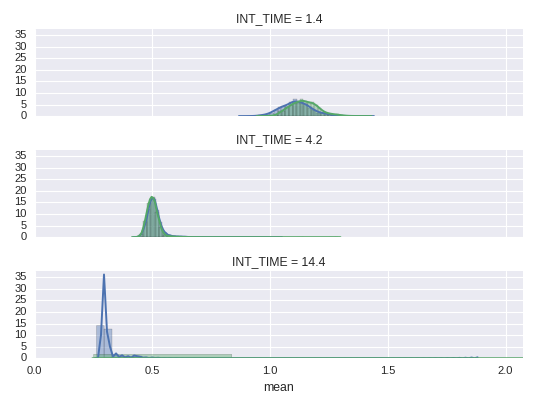

In [57]:
g = sns.FacetGrid(df, row='INT_TIME', hue='CHANNEL', size=1.7, aspect=4,)
g.map(sns.distplot, 'mean')

  max_open_warning, RuntimeWarning)



<IPython.core.display.Javascript object>


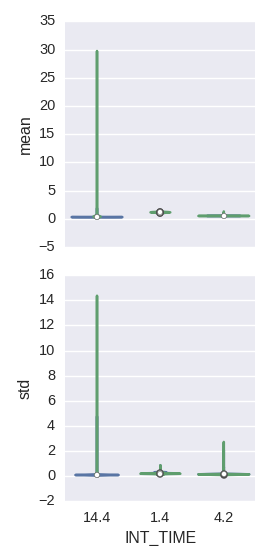

In [187]:
g = sns.PairGrid(df, x_vars=['INT_TIME'], hue='CHANNEL',
                y_vars=['mean','std'], size=3.5)
g.map(sns.violinplot)

In [33]:
df.sort_index(inplace=True)

# Odd things

## Difference between MIRROR_DEG and MIR_DEG

In [80]:
df['mirdeg_delta'] = df.MIRROR_DEG - df.MIR_DEG

<IPython.core.display.Javascript object>


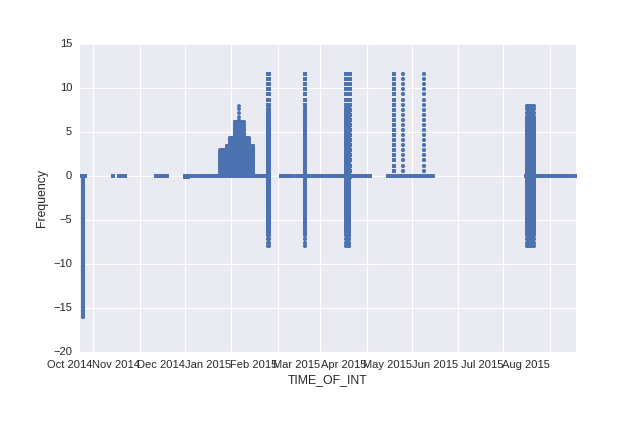

In [81]:
plt.figure()
df.mirdeg_delta.plot(style='.')